In [1]:
!python --version

Python 3.7.7


In [2]:
#https://stackoverflow.com/questions/53457975/pyspark-udf-function-error-in-lambda-function
import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("pyspark-notebook2").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "5g").\
        config("spark.mongodb.input.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.mongodb.output.uri","mongodb://mongo1:27017,mongo2:27018,mongo3:27019/database.horses_collection?replicaSet=rs0").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/spark-3.0.0-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6f59e8d3-ce41-474b-9580-886609128587;1.0
	confs: [default]
	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.0 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
downloading https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/3.0.0/mongo-spark-connector_2.12-3.0.0.jar ...
	[SUCCESSFUL ] org.mongodb.spark#mongo-spark-connector_2.12;3.0.0!mongo-spark-connector_2.12.jar (82ms)
downloading https://repo1.maven.org/maven2/org/mongodb/mongodb-driver-sync/4.0.5/mongodb-driver

In [4]:
spark.catalog.currentDatabase()

'default'

In [5]:
#reading dataframes from MongoDB

# sampleSize - https://stackoverflow.com/a/56255303
df = spark.read.format("mongo").option('sampleSize', 50000).load()
df.createOrReplaceTempView("mongo")


21/12/07 19:57:19 WARN MongoInferSchema: Field 'bsp' contains conflicting types converting to StringType
21/12/07 19:57:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- clk: string (nullable = true)
 |-- mc: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- marketDefinition: struct (nullable = true)
 |    |    |    |-- betDelay: integer (nullable = true)
 |    |    |    |-- bettingType: string (nullable = true)
 |    |    |    |-- bspMarket: boolean (nullable = true)
 |    |    |    |-- bspReconciled: boolean (nullable = true)
 |    |    |    |-- complete: boolean (nullable = true)
 |    |    |    |-- countryCode: string (nullable = true)
 |    |    |    |-- crossMatching: boolean (nullable = true)
 |    |    |    |-- discountAllowed: boolean (nullable = true)
 |    |    |    |-- eachWayDivisor: double (nullable = true)
 |    |    |    |-- eventId: string (nullable = true)
 |    |    |    |-- eventName: string (nullable = true)
 |    |    |    |-- eventTypeId: string (nullable = true)
 | 

In [7]:
df.show()

+--------------------+----------+--------------------+---+-------------+
|                 _id|       clk|                  mc| op|           pt|
+--------------------+----------+--------------------+---+-------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|
|[619e9dd8677066b2...|2481994285|[[1.124699287,, [...|mcm|1462557371191|
|[619e9dd8677066b2...|2482055516|[[1.124699287,, [...|mcm|1462557910955|
|[619e9dd8677066b2...|2482072939|[[1.124699287,, [...|mcm|1462558089056|
|[619e9dd8677066b2...|2482078964|[[1.124699287,, [...|mcm|1462558150717|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0.

In [8]:
#spark.sql("select * from mongo array_contains(root.mc, array('CLOSED'))").show()
from pyspark.sql.functions import explode   # Explodes lists into rows.

In [9]:
mc_exploded = df.select('*', explode(df.mc).alias('mc_row'))

In [10]:
md_only = mc_exploded.filter(mc_exploded.mc_row.marketDefinition.isNotNull())

In [11]:
md_only.show()

+--------------------+----------+--------------------+---+-------------+--------------------+
|                 _id|       clk|                  mc| op|           pt|              mc_row|
+--------------------+----------+--------------------+---+-------------+--------------------+
|[619e9dd8677066b2...|2480088678|[[1.124699287, [0...|mcm|1462537993283|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480249142|[[1.124699287, [0...|mcm|1462540135101|[1.124699287, [0,...|
|[619e9dd8677066b2...|2481803835|[[1.124699287, [0...|mcm|1462555384075|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482083965|[[1.124699287, [0...|mcm|1462558199155|[1.124699287, [0,...|
|[619e9dd8677066b2...|2482177634|[[1.124699287, [0...|mcm|1462559078531|[1.124699287, [0,...|
|[619e9dd8677066b2...|2480088678|[[1.124699285, [0...|mcm|1462537993283|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480212422|[[1.124699285, [0...|mcm|1462539800697|[1.124699285, [0,...|
|[619e9dd8677066b2...|2480409166|[[1.124699285, [0...|mcm|14

In [12]:
# Explode the marketDefinition array.
market_definitions = md_only.selectExpr('op AS operation_type',
                                        'clk AS sequence_token',
                                        'pt AS published_time',
                                        'mc_row.id AS market_id',
                                        'mc_row.rc AS rc',
                                        'mc_row.marketDefinition.betDelay AS bet_delay',
                                        'mc_row.marketDefinition.bettingType AS betting_type',
                                        'mc_row.marketDefinition.bspMarket AS bsp_market',
                                        'mc_row.marketDefinition.bspReconciled AS bsp_reconciled',
                                        'mc_row.marketDefinition.complete AS complete',
                                        'mc_row.marketDefinition.countryCode AS country_code',
                                        'mc_row.marketDefinition.crossMatching AS cross_matching',
                                        'mc_row.marketDefinition.discountAllowed AS discount_allowed',
                                        'mc_row.marketDefinition.eventId AS event_id',
                                        'mc_row.marketDefinition.eventName AS event_name',
                                        'mc_row.marketDefinition.eventTypeId AS event_type_id',
                                        'mc_row.marketDefinition.inPlay AS in_play',
                                        'mc_row.marketDefinition.marketBaseRate AS market_base_rate',
                                        'mc_row.marketDefinition.marketTime AS market_time',
                                        'mc_row.marketDefinition.marketType AS market_type',
                                        'mc_row.marketDefinition.numberOfActiveRunners AS number_of_active_runners',
                                        'mc_row.marketDefinition.numberOfWinners AS number_of_winners',
                                        'mc_row.marketDefinition.openDate AS open_date',
                                        'mc_row.marketDefinition.persistenceEnabled AS persistence_enabled',
                                        'mc_row.marketDefinition.runnersVoidable AS runners_voidable',
                                        'mc_row.marketDefinition.settledTime AS settled_time',
                                        'mc_row.marketDefinition.status AS status',
                                        'mc_row.marketDefinition.suspendTime AS suspend_time',
                                        'mc_row.marketDefinition.timezone AS timezone',
                                        'mc_row.marketDefinition.turnInPlayEnabled AS turn_in_play_enabled',
                                        'mc_row.marketDefinition.version AS version',
                                        'mc_row.marketDefinition.name AS market_name',
                                        'mc_row.marketDefinition.regulators AS regulators',
                                        'mc_row.marketDefinition.runners AS runners')

In [13]:
market_definitions = market_definitions.filter(market_definitions["status"]=="CLOSED")

In [14]:
market_definitions = market_definitions.filter(market_definitions["market_type"]=="WIN")

In [15]:
runners_only = market_definitions.filter(market_definitions.runners.isNotNull())

In [16]:
# Explode the Runners array.
runners_exploded = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [17]:
#############################
##### new dataset (just added BSP to the runners dataframe created above)
runners_exploded_wbsp = runners_only.select(market_definitions.operation_type,
                                       market_definitions.published_time,
                                       market_definitions.market_id,
                                       market_definitions.market_name,
                                       market_definitions.event_id,
                                       market_definitions.event_name,
                                       explode(market_definitions.runners).alias('runner_row'))

In [18]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_exploded_wbsp.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.bsp AS bsp',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [19]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp = runners_wbsp.filter(runners_wbsp.runner_status!='REMOVED')

In [20]:
##### new dataset (just added BSP to the runners dataframe created above)
runners_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER| 57.95|                   7|
|           mcm| 1462501034557|1.1246591

In [21]:
#############################

In [22]:
# Select the useful fields, and give them user friendly names.
runners = runners_exploded.selectExpr('operation_type',
                                      'published_time',
                                      'market_id',
                                      'market_name',
                                      'event_id',
                                      'event_name',
                                      'runner_row.id AS runner_id',
                                      'runner_row.name AS runner_name',
                                      'runner_row.status AS runner_status',
                                      'runner_row.sortPriority AS runner_sort_priority')

In [23]:
# Filter down to only the records that have rc (runner changes).
rc_only = mc_exploded.filter(mc_exploded.mc_row.rc.isNotNull())

In [24]:
# Explode the rc (runner changes) array.
rc_exploded = rc_only.select(rc_only.op.alias('operation_type'),
                             rc_only.pt.alias('published_time'),
                             rc_only.mc_row.id.alias('market_id'),
                             explode(rc_only.mc_row.rc).alias('runner_change_row'))

In [25]:
# Select the useful fields, and give them user friendly names.
runner_changes = rc_exploded.selectExpr('operation_type',
                                        'published_time',
                                        'market_id',
                                        'runner_change_row.id AS runner_id',
                                        'runner_change_row.ltp AS last_traded_price')

In [26]:
runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10861746|          B Brazin|      REMOVED|                   1|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|  4517788|       Great Value|      REMOVED|                   2|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May|   187960|        Kid Creole|      REMOVED|                   3|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [27]:
# https://www.researchgate.net/publication/351844751_Sonic_Thunder_vs_Brian_the_Snail_Are_people_affected_by_uninformative_racehorse_names
fast_names = [
    'a mile a minute', 'helter-skelter', 'quick-fire',
    'apace', 'high-speed quickly',
    'as fast as your legs would carry you',
    'hot', 'quickness',
    'as if it is going out of style', 'hotfoot', 'rapid',
    'at a rate of knots', 'hustle', 'rapid-fire',
    'at full pelt', 'in the twinkling of an eye',
    'rate',
    'at full speed', 'Jack Robinson', 'say',
    'at full tilt', 'lick', 'shot',
    'at full tilt', 'lickety-split', 'smartly',
    'before you can say Jack Robinson', 'lightning', 'souped-up',
    'blistering', 'like a shot', 'spanking',
    'breakneck' 'like a streak of lightning', 'speed',
    'brisk' 'like lightning spread', 'like wildfire',
    'chop-chop', 'meteoric', 'streak',
    'crash', 'mile', 'style',
    'express', 'nimble', 'superfast',
    'fast', 'nimbleness', 'supersonic',

    'fleet', 'nimbly', 'swift',
    'full', 'nippy', 'swiftly',
    'full steam ahead', 'pdq', 'thick',
    'gallop', 'pell-mell', 'thick and fast',
    'galloping', 'poky', 'tilt',
    'go like hot cakes', 'posthaste', 'top',
    'have a heavy foot', 'precipitous', 'twinkling',
    'headlong', 'precipitously', 'whoosh',
    'heavy', 'prompt', 'wildfire',
    'hell', 'promptly', 'zippy',
    'hell for leather', 'quick',


    'accelerated', 'high-speed', 'pell-mell',
    'at full speed', 'hurried', 'post-haste',
    'at full tilt', 'hurriedly', 'quick',
    'at speed', 'in a flash', 'quickly',
    'at the speed of light', 'in a hurry', 'rapid',
    'blistering', 'in a trice', 'rapidly',
    'breakneck', 'in a wink', 'smart',
    'brisk', 'in haste', 'speedily',
    'briskly', 'in time', 'speedy',
    'energetically', 'in no time at all', 'sporty',
    'expeditious', 'in the blink of an eye', 'sprightly',
    'expeditiously', 'like a flash', 'swift',
    'express', 'like a shot', 'swiftly',
    'fast', 'like an arrow from a bow', 'turbo',
    'fast-moving', 'lively', 'unhesitating',
    'fleet-footed', 'meteoric', 'whirlwind',
    'flying', 'nimble', 'with all haste',
    'hastily', 'on the double', 'with dispatch',
    'hasty', 'pell-mell', 'without delay',

    'acceleration', 'haste', 'scutter',
    'alacrity', 'hasten', 'sharpness',
    'blast', 'hurriedness', 'shoot',
    'bolt', 'hurry', 'spank along',
    'bowl along', 'hurry', 'speed',
    'briskness', 'hurtle', 'speediness',
    'career', 'immediacy', 'sprint',
    'celerity', 'momentum', 'stampede',
    'charge', 'pace', 'streak',
    'dart', 'precipitateness', 'sweep',
    'dash', 'promptness', 'swiftness',
    'dispatch', 'quickness', 'swoop',
    'expedition', 'race', 'tempo',
    'expeditiousness', 'rapidity', 'uzz',
    'fastness', 'rate', 'velocity',
    'flash', 'rattle along', 'whirl',
    'fly', 'run', 'whizz',
    'gallop', 'rush', 'whoosh',
    'go hell for leather', 'scramble', 'wing',
    'go like lightning', 'scud', 'zoom',
    'hare', 'scurry',

    'abrupt', 'impetuous', 'rushed',
    'agility', 'outrun', 'scramble',
    'dash', 'overhasty', 'speed',
    'disconcerted', 'overrun', 'speedily',
    'dodge', 'promptly', 'speedy',
    'haste', 'quick', 'sudden',
    'hastily', 'quickly', 'suddenly',
    'hurried', 'rapid', 'swift',
    'hurriedly', 'rapidly', 'swiftly',
    'hurry', 'rush', 'zoom',

    'accelerate', 'haste', 'race',
    'acceleration', 'hasten', 'rapidity',
    'agility', 'hie', 'rush',
    'airspeed', 'hurriedly', 'speedy',
    'celerity', 'hurry', 'stronghold',
    'dash', 'pace', 'swift',
    'decelerate', 'quick', 'swiftness',
    'expedite', 'quicken', 'tempo',
    'fast', 'quickly', 'urgently',
    'fastness', 'quickness', 'velocity',

    'Apache', 'Bentley', 'Blustery',
    'Bullet', 'Buzz', 'Comet',
    ',Cougar', ',Falcon', 'Faster',
    'Flash', 'Ghost', 'rider', 'Harley',
    'Jet', 'Jump', 'Jumping',
    'Miles', 'Mustang', 'Pony express',
    'Quick', 'Quicky', 'Racer',
    'Rapid', 'Rapide', 'Rocket',
    'Sonic', 'Speedy', 'Taz',
    'Tornado', 'Traveler', 'Wildfire',
    'Voyager', 'Wild', 'Velocity', 

    'Sonic Power', 'Speed Dragon', 'Zippy Lad', 'Lightening Vault',
    'Powerful Jet', 'Orbit Express', 'Swift Chap', 'Blazing Tempo',
    'Brave Falcon', 'Rush Now', 'Top Magic', 'Dixie Flyer',
    'Esprit De Bullet', 'Strike Fast', 'Hustle Hard', 'Diamond Rush',
    'Crown Me Fast', 'Hot Seat', 'Top Gear', 'Bright Bullet',
    'Quick Art', 'Rush Of Blood', 'Top Boy', 'Meteoric',
    'Moments',
    'One Wild Guy', 'Sonic Thunder', 'Grand Gallop', 'Zippy Speed',
    'Run for Roses', 'Saratoga',
    'Wildcat',
    'Quick Beers', 'Sudden Rush',
    'Flyingwithoutwings', 'Fast On', 'Dazzlem Quick', 'You Drive I Fly',
    'Irish Rocket', 'Hot Sauce', 'Mighty Flying', 'frost'
]

In [28]:
for i in range(len(fast_names)):
    fast_names[i] = fast_names[i].lower()

In [29]:
runners = runners.filter(runners.runner_status!='REMOVED')

In [30]:
runners.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5t

In [31]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, StringType, DoubleType

In [32]:
@udf(BooleanType())
def is_fast(name):
    if name is None:
        return False
    name = name.lower()
    for s in fast_names:
        if s in name:
            return True
    return False

In [33]:
from pyspark.sql.functions import lit, col

In [34]:
runners_fast = runners.withColumn('is_fast_horse',  is_fast(runners.runner_name))

In [35]:
#############################
### aisling with bsp data
runners_fast_wbsp = runners_wbsp.withColumn('is_fast_horse',  is_fast(runners_wbsp.runner_name)) 

In [36]:
### aisling with bsp data
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp.isNotNull())

In [37]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='None')

In [38]:
runners_fast_wbsp = runners_fast_wbsp.filter(runners_fast_wbsp.bsp!='NaN')

In [39]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [40]:
runners_fast_wbsp.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|   bsp|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|  13.5|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|  32.0|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER

In [41]:
## turning bsp to integer type
from pyspark.sql.types import IntegerType


In [42]:
runners_fast_wbsp = runners_fast_wbsp.withColumn("bsp", runners_fast_wbsp["bsp"].cast(IntegerType()))

In [43]:
runners_fast_wbsp.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('bsp', 'int'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [44]:
#runners_fast_wbsp.count()

In [45]:
#############################

In [46]:
runners_fast.dtypes

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [47]:
runners_fast.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10575249|       Bitsys Half|        LOSER|                   5|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10288198|         Blue Code|        LOSER|                   6|        false|
|           mcm| 1462501034557|1.124659130|     R8 1m Allw|27784588|EvangD (US) 5th May| 10116126|            Zartan|        LOSER|                   7|        false

In [48]:
runners_fast_only = runners_fast

In [49]:
runners_fast_only = runners_fast.filter(runners_fast.is_fast_horse=='true')

In [50]:
runners_fast_only.show()

+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|    market_name|event_id|         event_name|runner_id|       runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+---------------+--------+-------------------+---------+------------------+-------------+--------------------+-------------+
|           mcm| 1462495994956|1.124659121|    R5 6f Claim|27784588|EvangD (US) 5th May| 10116132|      Als Wild Cat|        LOSER|                   3|         true|
|           mcm| 1462492394718|1.124659115|R3 5f Mdn Claim|27784588|EvangD (US) 5th May| 11133644|       Smart Heath|        LOSER|                   4|         true|
|           mcm| 1462494555563|1.124659118|    R4 7f Claim|27784588|EvangD (US) 5th May| 10059691|Run Mardi Gras Run|        LOSER|                   2|         true

In [51]:
runners_fast_only_win = runners_fast_only.filter(runners_fast_only.runner_status=='WINNER')

In [52]:
runners_fast_only_win.show()

+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|operation_type|published_time|  market_id|       market_name|event_id|          event_name|runner_id|     runner_name|runner_status|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+------------------+--------+--------------------+---------+----------------+-------------+--------------------+-------------+
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462549406066|1.124660844|           7f Hcap|27785040|        Ling 6th May|  4776418|       Space War|       WINNER|                   5|         true|
|           mcm| 1462487628442|1.124659140|       R2 1m Claim|27784591|   Penn (US) 5th May|  9979505|Wild Imagination|       WINNER|                   2| 

In [53]:
###########################

In [54]:
runners_fast_wbsp_sample = runners_fast_wbsp.limit(1000)

In [55]:
runners_fast_wbsp_sample.show(100)

+--------------+--------------+-----------+-------------+--------+-------------+---------+------------------+-------------+---+--------------------+-------------+
|operation_type|published_time|  market_id|  market_name|event_id|   event_name|runner_id|       runner_name|runner_status|bsp|runner_sort_priority|is_fast_horse|
+--------------+--------------+-----------+-------------+--------+-------------+---------+------------------+-------------+---+--------------------+-------------+
|           mcm| 1462555329364|1.124663535|  1m Mdn Stks|27785190| Nott 6th May| 10412311|         Snow Moon|       WINNER|  2|                   2|        false|
|           mcm| 1462555329364|1.124663535|  1m Mdn Stks|27785190| Nott 6th May| 10463899|            Quebee|        LOSER| 11|                   3|        false|
|           mcm| 1462555329364|1.124663535|  1m Mdn Stks|27785190| Nott 6th May| 10322412|           Nicarra|        LOSER| 37|                   4|        false|
|           mcm| 14625

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

[('operation_type', 'string'),
 ('published_time', 'bigint'),
 ('market_id', 'string'),
 ('market_name', 'string'),
 ('event_id', 'string'),
 ('event_name', 'string'),
 ('runner_id', 'int'),
 ('runner_name', 'string'),
 ('runner_status', 'string'),
 ('runner_sort_priority', 'int'),
 ('is_fast_horse', 'boolean')]

In [56]:
columns_to_drop = ['operation_type', 'published_time', 'market_id', 'market_name', 'event_id', 'event_name', 'runner_id', 'runner_name', 'runner_sort_priority' ]


In [57]:
runners_fast_wbsp_sample1 = runners_fast_wbsp_sample.drop(*columns_to_drop)

In [58]:
runners_fast_wbsp_sample1.show()

+-------------+---+-------------+
|runner_status|bsp|is_fast_horse|
+-------------+---+-------------+
|       WINNER|  2|        false|
|        LOSER|  3|        false|
|        LOSER|  6|        false|
|        LOSER|  9|        false|
|        LOSER| 44|        false|
|        LOSER|  9|        false|
|        LOSER|  1|        false|
|        LOSER|  5|        false|
|        LOSER| 16|         true|
|       WINNER|  5|        false|
|        LOSER| 29|        false|
|        LOSER|247|        false|
|       WINNER|  1|        false|
|        LOSER|  4|        false|
|        LOSER|  8|        false|
|        LOSER| 22|        false|
|       WINNER|  4|        false|
|        LOSER|  6|        false|
|        LOSER|  5|        false|
|        LOSER|  5|        false|
+-------------+---+-------------+
only showing top 20 rows



In [59]:
### Sum of two or more columns in pyspark

from pyspark.sql.functions import col

In [111]:
runners_fast_wbsp_sample2=runners_fast_wbsp_sample1.withColumn("implied_prob", 1/col("bsp"))

In [61]:
runners_fast_wbsp_sample2.show(10)

+-------------+---+-------------+--------------------+
|runner_status|bsp|is_fast_horse|        implied_prob|
+-------------+---+-------------+--------------------+
|        LOSER| 13|        false| 0.07692307692307693|
|        LOSER| 32|        false|             0.03125|
|        LOSER| 57|        false|0.017543859649122806|
|        LOSER|223|        false|0.004484304932735426|
|        LOSER| 15|        false| 0.06666666666666667|
|        LOSER| 10|        false|                 0.1|
|        LOSER|  4|        false|                0.25|
|       WINNER| 26|        false|0.038461538461538464|
|        LOSER| 21|        false|0.047619047619047616|
|        LOSER|  2|        false|                 0.5|
+-------------+---+-------------+--------------------+
only showing top 10 rows



In [112]:
columns_to_drop = ["bsp"]
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop(*columns_to_drop)

In [63]:
runners_fast_wbsp_sample2.groupby("runner_status").count().show()

+-------------+-----+
|runner_status|count|
+-------------+-----+
|        LOSER|  872|
|       WINNER|  128|
+-------------+-----+



In [64]:
runners_fast_wbsp_sample2.groupby("is_fast_horse").count().show()

+-------------+-----+
|is_fast_horse|count|
+-------------+-----+
|        false|  920|
|         true|   80|
+-------------+-----+



In [69]:
runners_fast_wbsp_sample2.show()

+-------------+-------------+--------------------+
|runner_status|is_fast_horse|        implied_prob|
+-------------+-------------+--------------------+
|        LOSER|        false| 0.07692307692307693|
|        LOSER|        false|             0.03125|
|        LOSER|        false|0.017543859649122806|
|        LOSER|        false|0.004484304932735426|
|        LOSER|        false| 0.06666666666666667|
|        LOSER|        false|                 0.1|
|        LOSER|        false|                0.25|
|       WINNER|        false|0.038461538461538464|
|        LOSER|        false|0.047619047619047616|
|        LOSER|        false|                 0.5|
|        LOSER|        false|0.012048192771084338|
|        LOSER|        false|                 0.2|
|       WINNER|        false|                0.25|
|        LOSER|        false| 0.14285714285714285|
|        LOSER|        false| 0.08333333333333333|
|        LOSER|        false|                0.25|
|        LOSER|        false| 0

In [67]:
!pip install numpy

     |████████████████████████████████| 15.7 MB 5.4 MB/s            


In [113]:
from pyspark.ml.classification import LogisticRegression

In [114]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.withColumn("is_fast_horse_num", runners_fast_wbsp_sample2["is_fast_horse"].cast(IntegerType()))

In [115]:
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.drop("is_fast_horse")

In [78]:
runners_fast_wbsp_sample2.dtypes

[('runner_status', 'string'),
 ('implied_prob', 'double'),
 ('is_fast_horse_num', 'int')]

In [79]:
runners_fast_wbsp_sample2.show(1)

+-------------+------------------+-----------------+
|runner_status|      implied_prob|is_fast_horse_num|
+-------------+------------------+-----------------+
|       WINNER|0.3333333333333333|                0|
+-------------+------------------+-----------------+
only showing top 1 row



In [ ]:
cols = runners_fast_wbsp_sample2.columns

In [116]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['is_fast_horse_num']
#  is_fast_horse, runner_status, implied_prob
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'runner_status', outputCol = 'label')

stages += [label_stringIdx]

numericCols = ['implied_prob']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [117]:
# pipline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(runners_fast_wbsp_sample2)
runners_fast_wbsp_sample2 = pipelineModel.transform(runners_fast_wbsp_sample2)


In [120]:
selectedCols = ['label', 'features'] + cols
runners_fast_wbsp_sample2 = runners_fast_wbsp_sample2.select(selectedCols)
runners_fast_wbsp_sample2.printSchema()

root
 |-- runner_status: string (nullable = true)
 |-- implied_prob: double (nullable = true)
 |-- is_fast_horse_num: integer (nullable = true)
 |-- is_fast_horse_numIndex: double (nullable = false)
 |-- is_fast_horse_numclassVec: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [136]:
runners_fast_wbsp_sample2.head()

Row(runner_status='LOSER', implied_prob=0.5, is_fast_horse_num=0, is_fast_horse_numIndex=0.0, is_fast_horse_numclassVec=SparseVector(1, {0: 1.0}), label=0.0, features=DenseVector([1.0, 0.5]))

In [87]:
!pip install pandas

     |████████████████████████████████| 11.3 MB 5.1 MB/s            
     |████████████████████████████████| 503 kB 58.7 MB/s            


In [88]:
import pandas as pd

In [121]:
runners_fast_wbsp_sample2.dtypes

[('runner_status', 'string'),
 ('implied_prob', 'double'),
 ('is_fast_horse_num', 'int'),
 ('is_fast_horse_numIndex', 'double'),
 ('is_fast_horse_numclassVec', 'vector'),
 ('label', 'double'),
 ('features', 'vector')]

In [89]:
pd.DataFrame(runners_fast_wbsp_sample2.take(5), columns=runners_fast_wbsp_sample2.columns).transpose()

,0,1,2,3,4
label,1.0,0.0,0.0,0.0,0.0
features,"[1.0, 0.5]","[1.0, 0.029411764705882353]","[1.0, 0.03125]","[1.0, 0.25]","[1.0, 0.04]"
runner_status,WINNER,LOSER,LOSER,LOSER,LOSER
implied_prob,0.5,0.029412,0.03125,0.25,0.04
is_fast_horse_num,0,0,0,0,0
is_fast_horse_numIndex,0.0,0.0,0.0,0.0,0.0
is_fast_horse_numclassVec,(1.0),(1.0),(1.0),(1.0),(1.0)
label,1.0,0.0,0.0,0.0,0.0
features,"[1.0, 0.5]","[1.0, 0.029411764705882353]","[1.0, 0.03125]","[1.0, 0.25]","[1.0, 0.04]"


In [123]:
train, test = runners_fast_wbsp_sample2.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 712


Test Dataset Count: 288


In [124]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

21/12/07 21:31:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/07 21:31:37 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [126]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 5.4 MB/s            
     |████████████████████████████████| 1.1 MB 52.7 MB/s            
     |████████████████████████████████| 40 kB 7.0 MB/s             
     |████████████████████████████████| 884 kB 56.5 MB/s            
     |████████████████████████████████| 3.1 MB 66.0 MB/s            
     |████████████████████████████████| 97 kB 9.4 MB/s             


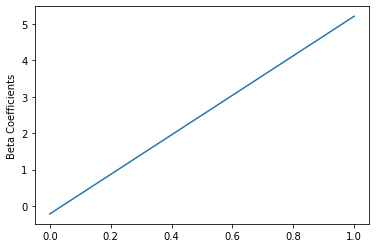

In [127]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

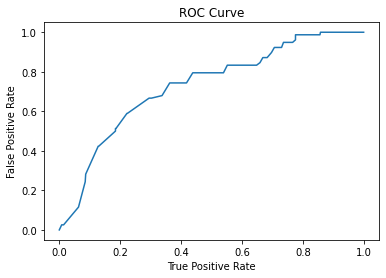

Training set areaUnderROC: 0.7282010838793173


In [128]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

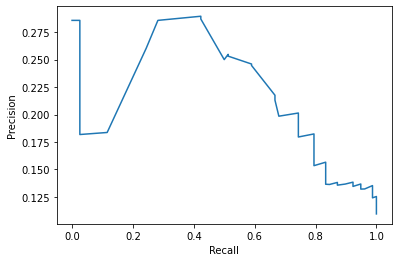

In [129]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [132]:
predictions = lrModel.transform(test)
predictions.select('is_fast_horse_num', 'implied_prob').show(10)

+-----------------+--------------------+
|is_fast_horse_num|        implied_prob|
+-----------------+--------------------+
|                0|               0.001|
|                0|0.003225806451612...|
|                0|0.003597122302158...|
|                0|0.003846153846153...|
|                0|0.004545454545454545|
|                0|  0.0045662100456621|
|                0|0.006097560975609756|
|                0|0.007692307692307693|
|                0|0.007692307692307693|
|                0|0.008333333333333333|
+-----------------+--------------------+
only showing top 10 rows



In [133]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8698966408268732


In [134]:
lrModel.coefficients

DenseVector([-0.2172, 5.2113])

the bigger the coefficient the more predictive power it has

Winner = 1, Loser = 0
Winner = X*is_fast + Y*implied_prob


the bigger the coefficient the more predictive power it has

is_fast=0, is_not_fast=1
Winner = 1, Loser = 0
Winner = -0.2172*is_fast + 5.2113*implied_prob

In [137]:
print("Multinomial coefficients: " + str(lrModel.coefficientMatrix))


Multinomial coefficients: DenseMatrix([[-0.21722497,  5.21125974]])



In [138]:
print("Multinomial intercepts: " + str(lrModel.interceptVector))

Multinomial intercepts: [-2.7164630059689507]


In [141]:
lrModel.summary()

TypeError: 'BinaryLogisticRegressionTrainingSummary' object is not callable